Text(0.5, 1.0, 'Distribution of Disease')

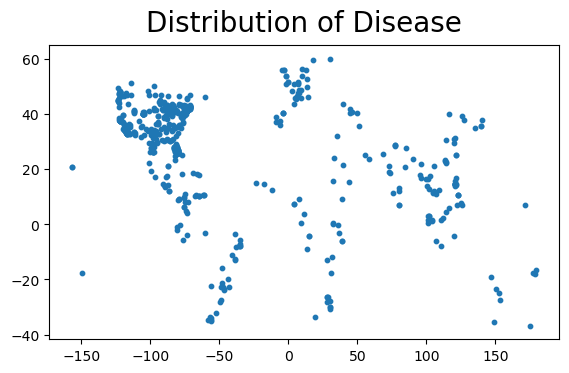

In [9]:
# Visualize distribution using long and lat
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(7.5, 7.5))

ax = fig.add_axes([0.2, 0.17, 0.68, 0.7], aspect=2)
ax.scatter(
    x=headline_df['longitude'], y=headline_df['latitude'], s = 10)
ax.set_title("Distribution of Disease", fontsize=20, verticalalignment='bottom')


In [148]:
# Cluster headlines using KMeans

from sklearn.cluster import KMeans
import numpy as np

def cluster_model(data, model, name = ''):
    features = data[['longitude', 'latitude']]
    cluster_column = 'assigned_clusters' + name
    data[cluster_column] = model.fit_predict(features)
    return data, len(set(data[cluster_column]))



In [144]:
import cartopy
from cartopy.crs import PlateCarree

def map_cluster_plot(data, clusters, name = ''):
    
    labels = set(clusters)
    # Number of clusters in labels, ignoring noise if present.
    n_clusters = len(set(clusters)) - (1 if -1 in labels else 0)
    
    plt.figure(figsize=(12, 8))
    ax = plt.axes(projection=PlateCarree())
    
    for index in range(n_clusters):
        selected_headlines = [data.loc[i] for i in data.index[:-1] 
                              if index == clusters.loc[i]]
        x_coordinates, y_coordinates = np.array(selected_headlines).T
        ax.scatter(x_coordinates, y_coordinates, s = 5)
    
    unclustered_cities = [data.loc[i] for i in data.index[:-1] 
                      if -1 == clusters.loc[i]]
    if np.array(unclustered_cities).T.size>0:
        x_coordinates, y_coordinates = np.array(unclustered_cities).T
        ax.scatter(x_coordinates, y_coordinates, s = 5, marker = '*', color = 'k')

    ax.set_global()
    ax.coastlines()
    # ax.add_feature(cartopy.feature.BORDERS)
    ax.add_feature(cartopy.feature.OCEAN)
    ax.add_feature(cartopy.feature.LAND)
    if len(name)>0:
        ax.set_title("Distribution of Disease {} Clusters by {}".format(n_clusters,name),
                 fontsize=15, verticalalignment='bottom')
    else:
        ax.set_title("Distribution of Disease {} Clusters".format(n_clusters,name),
                 fontsize=15, verticalalignment='bottom')
    plt.show()

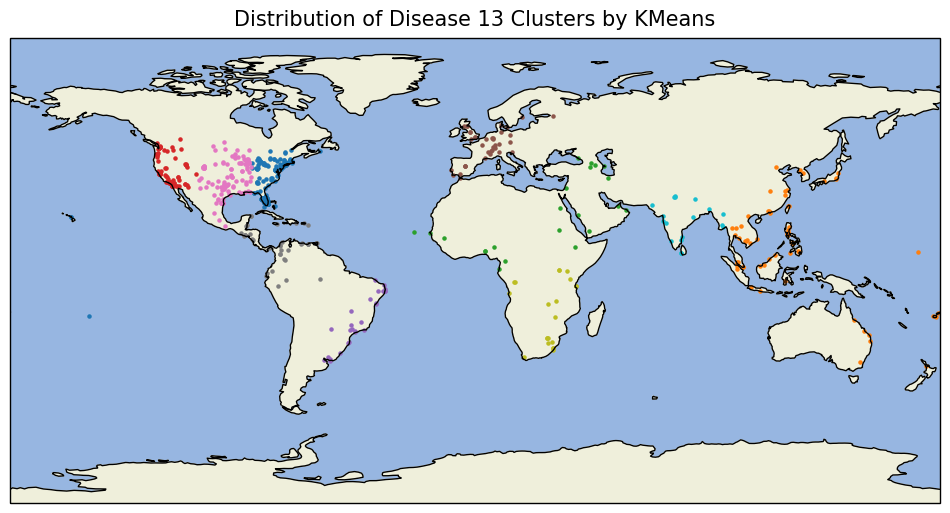

In [151]:
n_clusters = 13

model = KMeans(n_clusters = n_clusters)
_,_ = cluster_model(headline_df, model, name = 'KMeans')
map_cluster_plot(headline_df[['longitude','latitude']],headline_df['assigned_clustersKMeans'], name = 'KMeans')

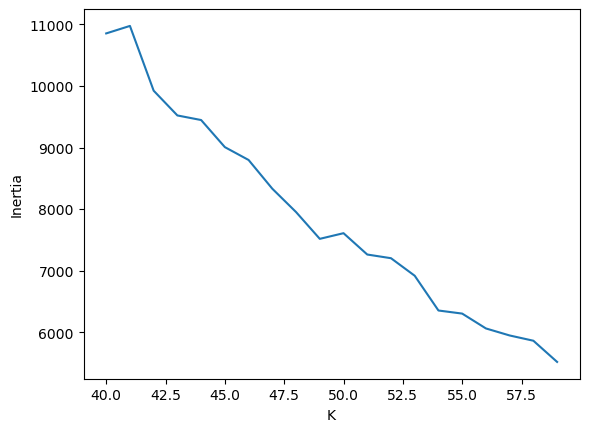

In [12]:
# Tune K with inertia
k_values = range(40,60)
inertia_values = [KMeans(k).fit(data).inertia_
                  for k in k_values]

plt.plot(k_values, inertia_values)
plt.xlabel('K')
plt.ylabel('Inertia')
plt.show() # looks like about 48

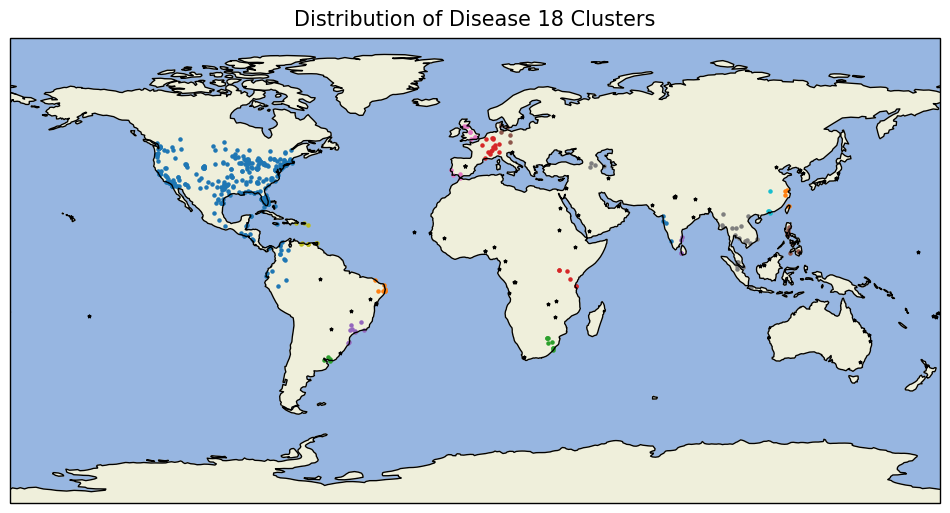

There are 19 clusters
There are 72 unclustered cities.


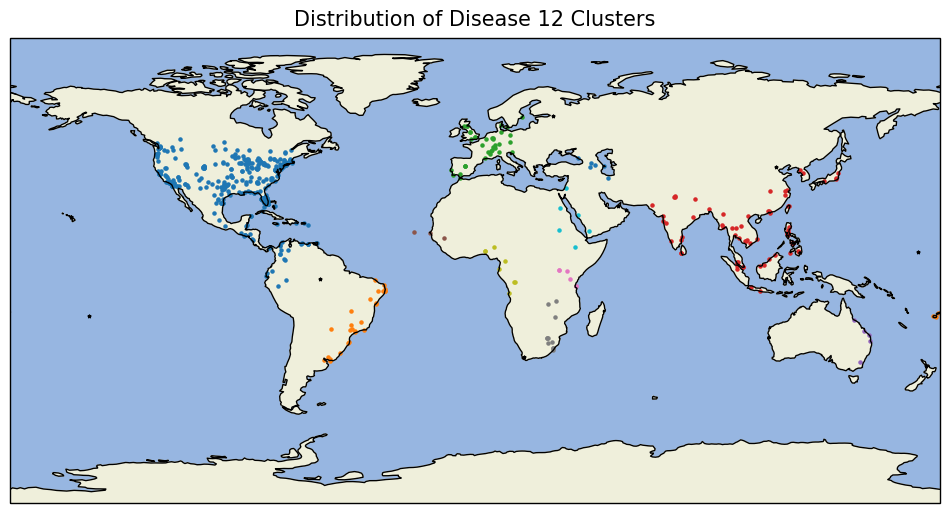

There are 13 clusters
There are 13 unclustered cities.


In [169]:
# Cluster with DBSCAN

from sklearn.cluster import DBSCAN
from math import cos, sin, asin

def travel_distance(coord1, coord2, radius=3956):
    """
    Calculates the great circle distance between two coordinates or arrays of coordinates.
    """
    if np.array_equal(coord1, coord2):
        return 0.0

    # Convert lat/lon to radians
    coord1, coord2 = np.radians(coord1), np.radians(coord2)
    # Find the difference between the coordinates
    delta_x, delta_y = coord2 - coord1
    
    # Apply Haversin formula
    haversin = np.sin(delta_x / 2) ** 2 + np.product(
        [np.cos(coord1[0]), np.cos(coord2[0]), np.sin(delta_y / 2) ** 2]
    )

    # Convert to distance in miles
    return 2 * radius * np.arcsin(haversin ** 0.5)

DB_travel = DBSCAN(eps=250, min_samples=4, metric = travel_distance)
DB_euclidean = DBSCAN(eps=9, min_samples=3, metric = 'euclidean')

for clusterer, name in [(DB_travel, 'DB_travel'), (DB_euclidean, 'DB_euclidean')]:
    _, n_clusters = cluster_model(headline_df,
                                        clusterer, 
                                        name = name)
    cluster_column = 'assigned_clusters' + name
    map_cluster_plot(headline_df[['longitude','latitude']],headline_df[cluster_column])
    unclustered_cities = [headline_df.loc[i] for i in headline_df.index[:-1] 
                      if -1 == headline_df[cluster_column].loc[i]]
    print('There are {} clusters'.format(n_clusters))
    print('There are {} unclustered cities.'.format(len(unclustered_cities)))


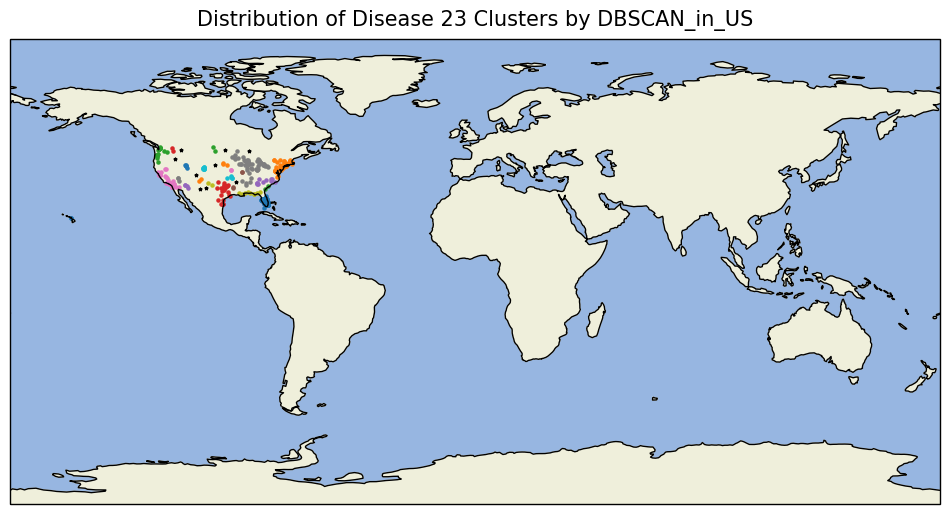

There are 24 clusters in DBSCAN_in_US
There are 9 unclustered cities in DBSCAN_in_US.


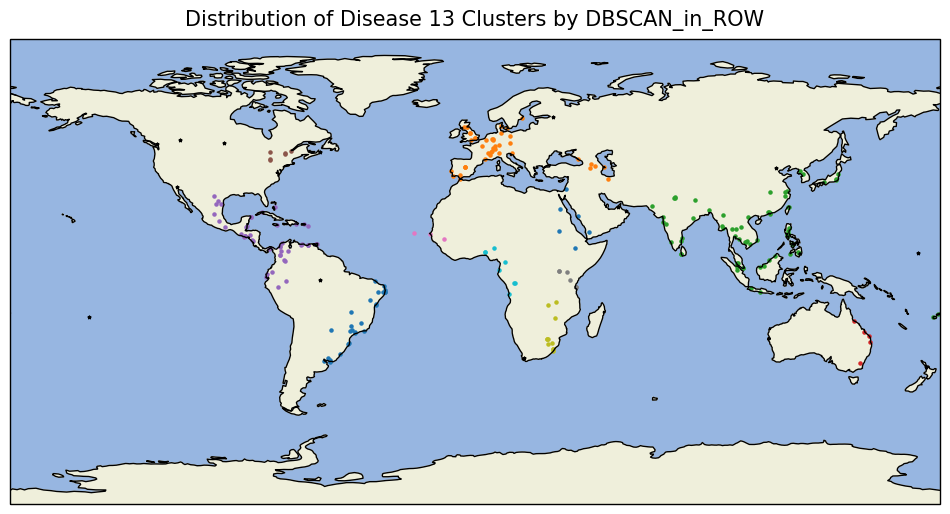

There are 14 clusters in DBSCAN_in_ROW
There are 15 unclustered cities in DBSCAN_in_ROW.


In [183]:
# Cluster on US separately with DBSCAN-Euclidean

headline_df_US = headline_df[headline_df['country code'] == 'US'].copy()
headline_df_ROW = headline_df[headline_df['country code'] != 'US'].copy()

params_US = {'eps':2, 'min_samples':2}
params_ROW = {'eps':9, 'min_samples':3}

for data, params, name in [(headline_df_US, params_US, 'DBSCAN_in_US'),
                           (headline_df_ROW,params_ROW, 'DBSCAN_in_ROW')]:
    clusterer = DB_euclidean
    clusterer.eps = params['eps']
    clusterer.min_samples = params['min_samples']
    _,n_clusters = cluster_model(data, clusterer, name = name)
    cluster_column = 'assigned_clusters' + name
    map_cluster_plot(data[['longitude','latitude']],data[cluster_column], name = name)
    unclustered_cities = [data.loc[i] for i in data.index[:-1] 
                      if -1 == data[cluster_column].loc[i]]
    print('There are {} clusters in {}'.format(n_clusters, name))
    print('There are {} unclustered cities in {}.'.format(len(unclustered_cities), name))
